# Market Basket Analysis in Python: 
An Implementation on Online Retail Data

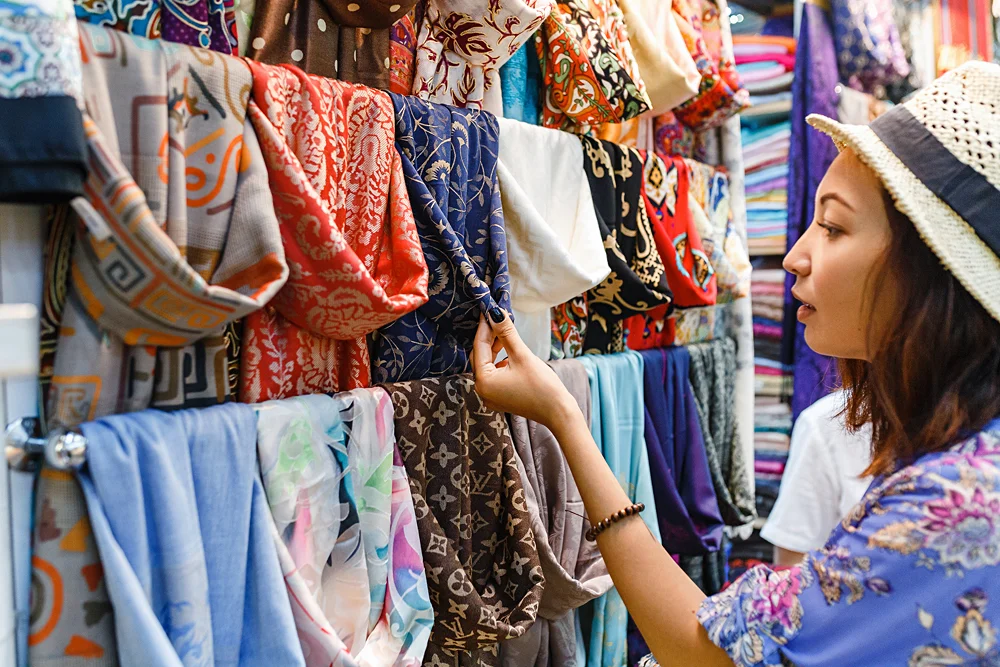

Market basket analysis is a technique used mostly by retailers to identify which products clients purchase together most frequently. This involves analyzing point of sale (POS) transaction data to identify the correlations between different items according to their co-occurrence in the data.

Using this information, retailers are better able to understand customer purchasing patterns, especially which items customers are likely to purchase together. A well-known example of market basket analysis in action is on the Amazon website. Upon selecting a product, a viewer is taken to the product page which not only includes details about the selected product but also displays a section called “Frequently bought together”.

Though familiar with online retailers, market basket analysis has its roots in brick-and-mortar stores, with decisions like which products to place in close proximity to each other, based on the results of the analysis. For example, if customers are buying steak, how likely are they to buy alcohol (and which type of alcohol)? This information can help guide decisions around product placement, up-selling and cross-selling. It also influences sales promotions, loyalty programs, and pricing strategies like bundling.

While several techniques exist for performing market basket analysis, Association Rules remains one of the most widely used. It identifies strong rules in transaction data by counting the frequency of items that occur together, and finding associations that occur more often than expected. One well-known association rule algorithm used in market basket analysis is the Apriori Algorithm. It works by first finding all frequent attributes in the data set, and then employing association rules based on two metrics, support, and confidence to identify the most important relationships.

In this code-along tutorial, we will focus on how to implement market basket analysis using the apriori algorithm and association rules in Python.

# The dataset

To perform our analysis, we’ll be using the Online Retail Dataset. This is a dataset containing transnational transactions made on a UK-based online retail store between 01/12/2010 and 09/12/2011. It comprises 541909 rows, with 8 attributes:

InvoiceNo: a unique 6-digit number assigned to each transaction. If this code starts with letter ‘C’, then the order was cancelled.

StockCode: a unique 5-digit number assigned to each distinct product.

Description: the product name.

Quantity: the number of each product (item) purchased per transaction.

InvoiceDate: the date and time each transaction was completed.

UnitPrice: the product price per unit in pounds sterling.

CustomerID: a unique 5-digit number assigned to each customer.

Country: the name of the country from where the purchase was made.

# Importing the libraries

We will begin by importing the relevant python libraries. For our analysis, we’ll be using Pandas for data manipulation, Matplotlib and Seaborn for visualization, and the mlextend library for applying the apriori algorithm and association rules.

In [7]:
# import all libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

The next step is to load our data into pandas. Since we’re dealing with an xlsx file, we’ll need to use the read_excel() method in pandas. We can also simply pass in the URL to the file as our argument. If you have downloaded the file to your computer, then you’ll need to specify the file path instead. After loading our data, we can preview the first 5 rows with the head() method.

In [8]:
#Load the file into pandas 
df = pd.read_excel('C:/Users/newton.mwalongo/OneDrive - MIC/DS Newton/Code/Apriori_MarketBasket/Online Retail.xlsx')
#Check the first 5 rows of the dataframe
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Using the info() method, we can check the structure of the dataset, including the number of rows and columns, as well as the names and data type of each column and whether or not they contain null values.

In [9]:
# check structure of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


# Preparing the data

Our first task in preparing the data is to check the occurrence of null values in the dataset by using the isna() method. By including the sum() method, we can view the total number of null values per column.

In [10]:
# check the occurence of null values
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

The dataset contains a total of 136,534 null values, with the vast majority occurring in the CustomerID column. Since we have more than sufficient data for our analysis, we will not bother with trying to impute these missing values, and will simply remove them from the data

In [11]:
# Before dropna
len(df)

541909

In [13]:
# After dropna
df.dropna(inplace=True)
len(df)

406829

After removing all null values, we’re left with 406,829 rows of data. Next, we’d want to remove all canceled transactions from the data. Remember from the description of the dataset that Invoice Numbers that start with a “C” are canceled/returned transactions. We can easily remove these by first converting the InvoiceNo column to a string data type, and then removing all rows that start with a “C” with a simple filter.

In [15]:
# Convert the InvoiceNo column to string
df['InvoiceNo'] = df['InvoiceNo'].astype('str')

# Remove rows with invoices that contain a "C"
df = df[~df['InvoiceNo'].str.contains('C')]

len(df)

397924

After removing all canceled transactions, we’re left with 397,924 rows of data. Our final preparation task is to choose transactions from only one country for our analysis. Before we do so, we can first check how all the transactions are distributed by country with the value_counts() method. We’ll limit it to the top 5 countries for easy visibility.

In [16]:
# check the distribution of transactions per country
top10 = df['Country'].value_counts().head()
top10

United Kingdom    354345
Germany             9042
France              8342
EIRE                7238
Spain               2485
Name: Country, dtype: int64

The UK is clearly number one in terms of the number of transactions. We can visualize this information in a pie chart as well.

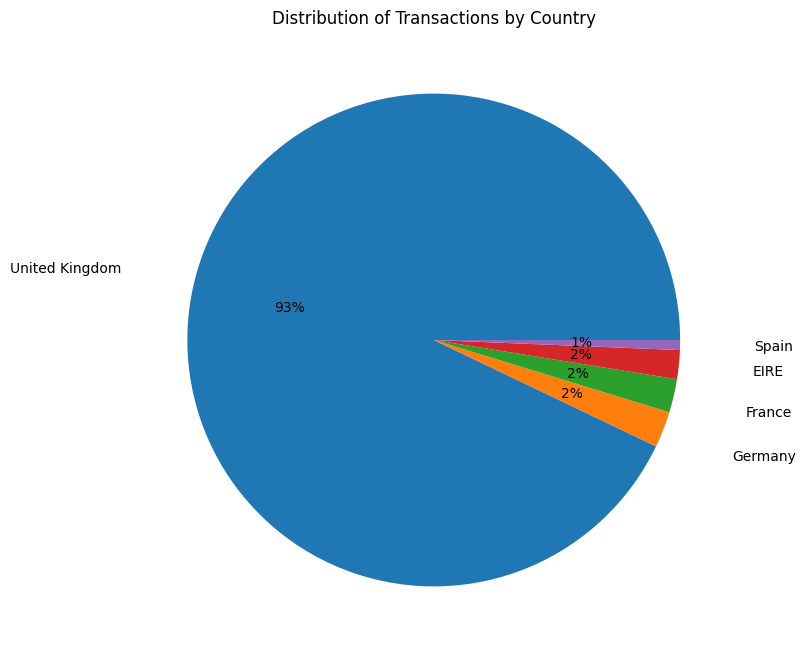

In [17]:
# Visualize above report in a piechart
# Create piechart to show distributions of transactions
plt.figure(figsize=[8,8])
plt.pie(top10, labels=top10.index, autopct = '%0.0f%%', labeldistance=1.3)
plt.title("Distribution of Transactions by Country")
plt.show()

A whopping 93% of all transactions originated from the UK. To keep things simple, we will limit our analysis to the UK only. We will also need to group our data by transaction (InvoiceNo) and item (Description). This will show the quantity of each item purchased. We will then need to sum up these values and unstack them. Finally, we will change the index of the dataframe to the InvoiceNo in order to display the quantity of each item purchased for every transaction. We can do all of these in a single line of code as per below.

In [19]:
# Group, sum, unstack and set index of dataframe
basket = df[df['Country'] == 'United Kingdom']\
         .groupby(['InvoiceNo','Description'])['Quantity']\
         .sum().unstack()\
         .reset_index().fillna(0)\
         .set_index('InvoiceNo')
         
basket.head()

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Here’s what the first five rows look like. Note that there are currently only zeros in the preview, but if you looked through the entire dataset you’ll notice some other values as well. Our next task is to hot encode our data. To do this, we can create a simple function to convert any values above zero to a 1, and any zeros to 0. We can then apply the function using the applymap() method.

In [21]:
# Create function to hot encode the values
def encode_values(x):
    if x<=0:
        return 0
    if x>=1:
        return 1
    
# Apply function to data
basket_encoded = basket.applymap(encode_values)

basket_encoded

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581583,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581584,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The final step in the data preparation stage is to remove all invoices that have only one item. Since we’re analyzing items bought together, a single-item invoice will be of no use to us.

In [22]:
# filter for only invoices with 2 or more items
basket_filtered = basket_encoded[(basket_encoded > 0).sum(axis=1) >= 2]

basket_filtered

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536372,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581583,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581584,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We’re now down to 15376 rows of data, a decrease of 7.65% from the 16649 we had after hot encoding. This means 92.35% of the data represents two or more transactions. Now that the data is prepared and properly structured, we can begin performing our market basket analysis.

# Apply the apriori algorithm

In this section, we will apply the apriori algorithm to find the most frequently purchased items in the dataset. For our minimum support value, we will specify 3%, which means only items whose frequency of occurrence in the data is at least 3% will be returned.

In [25]:
# Generate the frequent itemsets
frequent_itemsets = apriori(basket_filtered, min_support=0.03, use_colnames=True).sort_values('support', ascending=False)
frequent_itemsets.head(10)

c:\Users\newton.mwalongo\AppData\Local\Programs\Python\Python39\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
99,0.121358,(WHITE HANGING HEART T-LIGHT HOLDER)
44,0.093197,(JUMBO BAG RED RETROSPOT)
80,0.090466,(REGENCY CAKESTAND 3 TIER)
6,0.084417,(ASSORTED COLOUR BIRD ORNAMENT)
71,0.082986,(PARTY BUNTING)
58,0.072841,(LUNCH BAG RED RETROSPOT)
86,0.064971,(SET OF 3 CAKE TINS PANTRY DESIGN )
52,0.064646,(LUNCH BAG BLACK SKULL.)
69,0.061004,(PAPER CHAIN KIT 50'S CHRISTMAS )
64,0.060939,(NATURAL SLATE HEART CHALKBOARD )


From the results, we can see that the “White hanging Heart T-Light Holder” is the most frequently purchased item with a support value of 0.121358, meaning it was purchased in 12% of all transactions.

# Applying association rules

The final step in our analysis is to generate the rules with their corresponding support, confidence, and lift. From this, we can then extract useful information about which items are more likely to be purchased together.

In [29]:
# Apply association rules
assoc_rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1).sort_values('lift', ascending=False).reset_index(drop=True)
assoc_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.039802,0.043900,0.030957,0.777778,17.717202,0.029210,4.302452
1,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.043900,0.039802,0.030957,0.705185,17.717202,0.029210,3.256952
2,(LUNCH BAG RED RETROSPOT),(LUNCH BAG PINK POLKADOT),0.072841,0.055086,0.030632,0.420536,7.634188,0.026620,1.630668
3,(LUNCH BAG PINK POLKADOT),(LUNCH BAG RED RETROSPOT),0.055086,0.072841,0.030632,0.556080,7.634188,0.026620,2.088574
4,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.052680,0.093197,0.032908,0.624691,6.702899,0.027999,2.416152
5,(JUMBO BAG RED RETROSPOT),(JUMBO BAG PINK POLKADOT),0.093197,0.052680,0.032908,0.353105,6.702899,0.027999,1.464412
6,(LUNCH BAG BLACK SKULL.),(LUNCH BAG RED RETROSPOT),0.064646,0.072841,0.031478,0.486922,6.684737,0.026769,1.807051
7,(LUNCH BAG RED RETROSPOT),(LUNCH BAG BLACK SKULL.),0.072841,0.064646,0.031478,0.432143,6.684737,0.026769,1.647164


Based on the results from implementing association rules, we can see that “Roses Regency Teacup and Saucer” and “Green Regency Teacup and Saucer” have the highest “lift” value, and therefore the highest association of any two products. With a combined support of 0.0309, it means both items were purchased together in 3.09% of all transactions.

As far as what marketing strategy to implement with this insight, that will depend on a variety of factors and is a perfect example of how domain knowledge in retail will come in handy. Given that this is an online store, it’s a no-brainer to display each consequent product as a recommendation on the antecedent product page, thereby using the popularity of one product to drive the sales of the other. Another way to attract more sales is to bundle the associated products and implement a bundle pricing technique or a sales promotion around both items.

# Conclusion

In this article, we successfully implemented market basket analysis on a retail dataset using the apriori algorithm and association rules. The great part of this process is that it is relatively easy to implement and interpret, the result of which can be used to make data-driven, strategic marketing decisions. In addition to its usefulness to retailers, market basket analysis is also applicable in other domains, such as in the manufacturing industry for predictive analysis on equipment failure, in the pharmaceutical industry for the discovery of co-occurence relationships among diagnosis and active ingredients, and in finance for fraud detection.

Thank you so much for reading. I hope you enjoyed the article and that you learned something new. If you do have any suggestions, comments, or questions, feel free to add a comment . All the best in your data journey!